<a href="https://colab.research.google.com/github/alfinmaulani/skripsi/blob/master/combined(glove).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade scikit-learn
import numpy as np
import pandas as pd
import io
import os
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
import gensim

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
url0='https://raw.githubusercontent.com/alfinmaulani/skripsi/master/dataISEAR.csv'
df = pd.read_csv(url0)

In [ ]:
# df=df.drop(df[df['emosi'] == 'shame'].sample(frac=1).index)
# df=df.drop(df[df['emosi'] == 'guilt'].sample(frac=1).index)

In [3]:
df.emosi.value_counts()

joy        1092
sadness    1082
anger      1079
fear       1076
shame      1071
disgust    1066
guilt      1050
Name: emosi, dtype: int64

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df2 = pd.read_csv('/content/drive/MyDrive/twitter_prosessed.csv')

In [6]:
df3 = pd.read_csv('/content/drive/MyDrive/idwiki_new_lower.txt', delimiter = "\t")
df3.columns = ["arti"]

preputama : lower case

In [7]:
def lower(temp):
  return temp.str.lower()

In [8]:
df['dokumen']=lower(df['dokumen'])

In [9]:
df2['tweet']=lower(df2['tweet'])

In [10]:
df3['arti']=lower(df3['arti'])

preputama : Pembersihan noise (over enter and space)

In [11]:
def bersih_noise(temp):
  temp=temp.replace(' \n', ' ', regex=True)
  temp=temp.replace('   ', ' ', regex=True)
  return temp.replace('  ', ' ', regex=True)

In [12]:
df=bersih_noise(df)

In [13]:
df2=bersih_noise(df2)

In [14]:
df3=bersih_noise(df3)

preptambah : expand contractions

In [15]:
!pip install contractions
import contractions

     |████████████████████████████████| 321 kB 28.9 MB/s 
     |████████████████████████████████| 284 kB 44.4 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85445 sha256=886262aa1bc1581b1e21b0b4afdc786b109cd295b698506a3b407d5755c08f85
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [16]:
def expand_word(temp):
  expanded_words = []   
  for word in temp:
    expanded_words.append(contractions.fix(word))
  return expanded_words

In [17]:
df.dokumen=expand_word(df.dokumen)

In [18]:
df2.tweet=expand_word(df2.tweet)

In [19]:
df3.arti=expand_word(df3.arti)

preputama : cleansing punctuation

In [20]:
def clns_punc(temp):
  return temp.str.replace(r'[^\w\s]+', '')

In [21]:
df['dokumen'] = clns_punc(df['dokumen'])

In [22]:
df2['tweet'] = clns_punc(df2['tweet'])

In [23]:
df3['arti'] = clns_punc(df3['arti'])

preputama : cleansing number

In [24]:
!pip install tweet-preprocessor
import preprocessor as p

In [25]:
p.set_options(p.OPT.NUMBER)
def clns_numb(temp):
  sementara=[]
  for word in temp:
    sementara.append(p.clean(word))
  return sementara

In [26]:
df.dokumen=clns_numb(df.dokumen)

In [27]:
df2.tweet=clns_numb(df2.tweet)

In [28]:
df3.arti=clns_numb(df3.arti)

preptambah : remove stopword

In [29]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [30]:
pat = r'\b(?:{})\b'.format('|'.join(stop))
def remove_stopw(temp):
  temp=temp.str.replace(pat, '')
  return temp.str.replace(r'\s+', ' ')

In [31]:
df['dokumen'] = remove_stopw(df['dokumen'])

In [32]:
df2['tweet'] = remove_stopw(df2['tweet'])

In [33]:
df3['arti'] = remove_stopw(df3['arti'])

tokenizing

In [34]:
def token(temp):
  return [word_tokenize(x) for x in temp]

In [35]:
df.dokumen=token(df.dokumen)

In [36]:
df2.tweet=token(df2.tweet)

In [37]:
df3.arti=token(df3.arti)

preptambah : Lemmatization

In [38]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [39]:
def lemma(temp):
  temp.apply(lambda x: [stemmer.stem(y) for y in x])

In [40]:
lemma(df['dokumen'])

In [41]:
lemma(df2['tweet'])

In [42]:
lemma(df3['arti'])

save df

In [ ]:
# df.to_csv(r'dataisear(preptambah).csv', index = False)

gabung corpus

In [ ]:
# sent=df.dokumen

In [ ]:
# sent=df2.tweet.append(df.dokumen,ignore_index=True)

In [ ]:
# sent=df3.arti.append(df.dokumen,ignore_index=True)

In [43]:
sent=df3.arti.append(df2.tweet.append(df.dokumen,ignore_index=True),ignore_index=True)

glove

In [44]:
!pip install glove-python-binary

     |████████████████████████████████| 948 kB 28.6 MB/s 


In [45]:
from glove import Glove
from glove import Corpus

In [46]:
korpus = Corpus()
korpus.fit(sent, window=5, ignore_missing=False,)

In [ ]:
# (corpus, window=10, ignore_missing=False)

In [47]:
glove = Glove(no_components=100, learning_rate=0.05, alpha=0.025, max_count=100, max_loss=10.0, random_state=None)
glove.fit(korpus.matrix)
glove.add_dictionary(korpus.dictionary)

In [ ]:
# (no_components=30, learning_rate=0.05, alpha=0.75, max_count=100, max_loss=10.0, random_state=None)

cek model

In [48]:
glove.word_vectors.shape

(1003499, 100)

In [49]:
glove.word_vectors[glove.dictionary['moment']]

array([-0.13348407,  0.21658169,  0.12056741, -0.03011247, -0.05961268,
       -0.34895202, -0.07306302,  0.10518288,  0.05861899, -0.10721032,
        0.14470617, -0.07628201,  0.0118125 ,  0.17065328,  0.08763351,
        0.0371425 ,  0.10328008,  0.0821394 , -0.15408125,  0.08051707,
       -0.2726572 , -0.21288609,  0.07183247, -0.03574021,  0.03925996,
        0.1099704 ,  0.08936446,  0.11846842, -0.09385926, -0.08594859,
        0.06516864,  0.05380784,  0.15675724,  0.51381984,  0.00309105,
       -0.23024531,  0.14204092, -0.0408535 ,  0.04626704, -0.11382082,
        0.03635501,  0.27866752, -0.3215481 ,  0.30387838, -0.01465274,
       -0.15683099,  0.12047505, -0.09335905, -0.14654249,  0.03711119,
       -0.04770465, -0.22563462, -0.04133089, -0.06594067,  0.23981684,
        0.20765497, -0.24091866, -0.06481929, -0.04344836,  0.14744391,
        0.33572914,  0.31433594,  0.03938134, -0.06217806, -0.01148181,
       -0.08819232, -0.12934406,  0.05205441,  0.17332791,  0.05

ekstraksi fitur

In [50]:
import array
ekstrak=[]
temp=array.array('i',(0,)*100)
for senten in df.dokumen:
  for word in senten:
    temp=np.add(temp,glove.word_vectors[glove.dictionary[word]])
  temp=temp/len(senten)
  ekstrak.append(temp)
has_vec=ekstrak

In [51]:
X=has_vec
y=df.emosi
print(np.shape(X))
print(np.shape(y))
# print(X)
# print(y)

(7516, 100)
(7516,)


klasifikasi svm

In [52]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [ ]:
# langsung cari score

# clf = svm.SVC(kernel='poly', decision_function_shape='ovr')
# scores = cross_val_score(clf, X, y, cv=10)
# # scores.mean()

conf matrix dan akurasi

In [53]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
# svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, 
#  class_weight=None, verbose=False, max_iter=- 1, decision_function_shape='ovr', break_ties=False, random_state=None)

In [ ]:
# cross_val_predict(estimator, X, y=None, *, groups=None, cv=None, n_jobs=None, verbose=0, fit_params=None, 
# pre_dispatch='2*n_jobs', method='predict')

In [54]:
def klasifikasi(krnl):
  clf = svm.SVC(kernel=krnl, decision_function_shape='ovr')
  y_pred = cross_val_predict(clf, X, y, cv=10)
  ConfusionMatrixDisplay.from_predictions(y, y_pred)
  plt.show()
  print(accuracy_score(y, y_pred))
  print(precision_recall_fscore_support(y, y_pred, average='macro'))

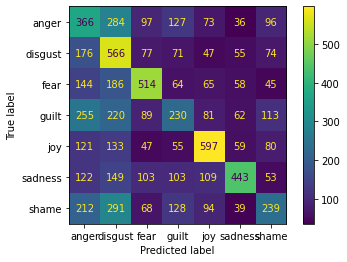

0.39316125598722723
(0.41063013503257345, 0.3923126875536357, 0.3915839172898274, None)


In [55]:
klasifikasi('poly')

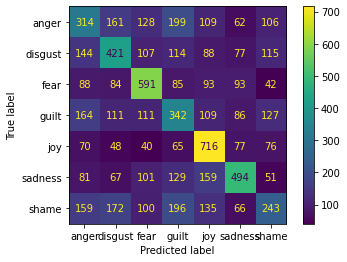

0.41524747205960616
(0.4075783764311146, 0.414292236317148, 0.40795492672511263, None)


In [56]:
klasifikasi('rbf')

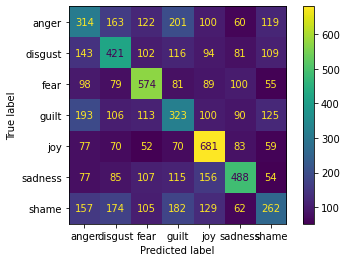

0.4075306013837147
(0.4015670152997205, 0.40661357436665796, 0.40180033881873617, None)


In [57]:
klasifikasi('linear')